## Driver Score
We identify driver TFs underlying epigenetic and transcriptomics change between control and AUD using a correlation model. We normalized the GRN and then calculated the Pearson Correlation Coefficient (PCC) between expression or chromatin accessibility fold change and the regulatory strength of TGs or REs for each TF.  
我们利用相关模型确定了对照组和 AUD 之间表观遗传学和转录组学变化的驱动 TF。我们将 GRN 归一化，然后计算每个 TF 的表达或染色质可及性折叠变化与 TG 或 RE 的调控强度之间的皮尔逊相关系数 (PCC)。

## Request
Please complete the following tutorials

1. PBMCs tutorial
2. Downstream analysis-Module detection

就是说这一步是下游分析的终点步骤

## Transcriptomics driver score

In [ ]:
import pandas as pd
TG_pseudobulk = pd.read_csv('data/TG_pseudobulk.tsv',sep=',',header=0,index_col=0)
TG_pseudobulk = TG_pseudobulk[~TG_pseudobulk.index.str.startswith('MT-')] # remove the mitochondrion, if the species is mouse, replace 'MT-' with 'mt-'
import scanpy as sc
adata_RNA = sc.read_h5ad('data/adata_RNA.h5ad')
label_all = adata_RNA.obs[['barcode','sample','label']]
label_all.index = label_all['barcode']
metadata = label_all.loc[TG_pseudobulk.columns]
metadata.columns = ['barcode','group','celltype']
GRN='trans_regulatory'
adjust_method='bonferroni' 
corr_method='pearsonr'
import numpy as np
from LingerGRN import Compare
C_result_RNA_sp,P_result_RNA_sp,Q_result_RNA_sp=Compare.driver_score(TG_pseudobulk,metadata,GRN,outdir,adjust_method,corr_method)
K=3 # We choose the top K positive and negative TFs to save to the txt file for visualization purposes.
C_result_RNA_sp_r,Q_result_RNA_sp_r=Compare.driver_result(C_result_RNA_sp,Q_result_RNA_sp,K)
C_result_RNA_sp_r.to_csv('C_result_RNA_sp_r.txt',sep='\t')
Q_result_RNA_sp_r.to_csv('Q_result_RNA_sp_r.txt',sep='\t')

The adjust_method is the p-value adjust method, you could choose one from the following:

•bonferroni : one-step correction  
•sidak : one-step correction  
•holm-sidak : step down method using Sidak adjustments  
•holm : step-down method using Bonferroni adjustments  
•simes-hochberg : step-up method (independent)  
•hommel : closed method based on Simes tests (non-negative)  
•fdr_bh : Benjamini/Hochberg (non-negative)  
•fdr_by : Benjamini/Yekutieli (negative)  
•fdr_tsbh : two stage fdr correction (non-negative)  
•fdr_tsbky : two stage fdr correction (non-negative)  

### visualize

In [ ]:
import os
os.environ['R_HOME'] = '/data2/duren_lab/Kaya/conda_envs/LINGER/lib/R'  # Replace with your actual R home path
import rpy2.robjects as robjects
from rpy2.robjects import r
# Import the R plotting package (ggplot2 as an example)
r('library(ggplot2)')
r('library(grid)')
# Create data in R environment through Python
r('''
dataP=read.table('Q_result_RNA_sp_r.txt',sep='\t',row.names=1,header=TRUE)
dataT=read.table('C_result_RNA_sp_r.txt',sep='\t',row.names=1,header=TRUE)
sort_TF=rownames(dataT)
library(tidyr)
dataP=-log10(dataP)
print(paste0('maxinum of -log10P:',max(dataP)))
dataP[dataP>40]=40
dataP1=dataP
dataP1$TF=rownames(dataP)
longdiff0 <- gather(dataP1, sample, value,-TF)
longdiff0_s <- longdiff0[order(longdiff0$TF, longdiff0$sample), ]
dataT1=dataT
dataT1$TF=rownames(dataT)
longdiff1=gather(dataT1, sample, value,-TF)
longdiff1=longdiff1[order(longdiff1$TF, longdiff1$sample), ]
colnames(longdiff1)=c('TF','celltype','PCC')
longdiff1$P=longdiff0_s$value
longdiff1$TF=factor(longdiff1$TF,levels=rev(sort_TF))
library(egg)
limits0=c(2,ceiling(dataP))
range0 = c(1,4)
breaks0 = c(2,(ceiling(dataP)-2)*1/4+2,(ceiling(dataP)-2)*2/4+2,(ceiling(dataP)-2)*3/4+2,ceiling(dataP))
p=ggplot(longdiff1,aes(x = celltype, y = TF))+
geom_point(aes(size = P, fill = PCC), alpha = 1, shape = 21) + 
  scale_size_continuous(limits = c(4, 40), range = c(1,5), breaks = c(4,10,20,30,40)) + 
  labs( x= "cell type", y = "TF", fill = "")  + theme_article()+
  theme(legend.key=element_blank(), 
  axis.text.x = element_text( size = 9, face = "bold", angle = 0, vjust = 0.3, hjust = 1), 
  legend.position = "right") + 
  scale_fill_gradient2(midpoint=0, low="blue", mid="white",
                     high="red", space ="Lab" )


''')
r('''
annotation_row=read.table('Module.txt',sep='\t',header=TRUE,row.names=1)
library(pheatmap)
anno1=data.frame(annotation_row[match(rownames(dataP), rownames(annotation_row)), ])
colnames(anno1)=c('TG')
rownames(anno1)=rownames(dataP)
anno1[is.na(anno1)]=0
anno1[,1]=paste0('M',anno1[,1])
anno1$name=rownames(anno1)
longdiff0 <- gather(anno1, sample, value,-name)
longdiff0$name=factor(longdiff0$name,levels=rownames(anno1))
library("RColorBrewer")
ann_colors = c('M0'="gray", 'M1'='#ffe901','M2'="#be3223",'M3'='#098ec4','M4'='#ffe901','M5'='#f8c9cb','M6'='#f8c9cb',
'M7'='#b2d68c','M8'='#f2f1f6','M9'='#c7a7d2','M10'='#fcba5d')
#ann_colors = list("gray", '#ffe901',"#be3223",'#098ec4','#ffe901','#f8c9cb','#f8c9cb','#b2d68c','#f2f1f6','#c7a7d2','#fcba5d')
heatmap_plot <- ggplot(longdiff0, aes(x = sample, y =name , fill = value)) +
  geom_tile(width = 0.9, height = 0.9) + scale_fill_manual(values=ann_colors) +
  theme_article()+theme(text = element_text(size = 9), legend.position = "left")
  ''')
r('''
widths <- c(4.5, 4.5+dim(dataP)[2]) 
print(unique(longdiff0$value))
pdf('driver_trans.pdf',width=6/16*(9+dim(dataP)[2]),height= dim(anno1)[1]/10+0.5)
#print(heatmap_plot)
grid.arrange(heatmap_plot, p, ncol = 2,widths = widths)
dev.off()
''')

The figure is saved to driver_trans.pdf.
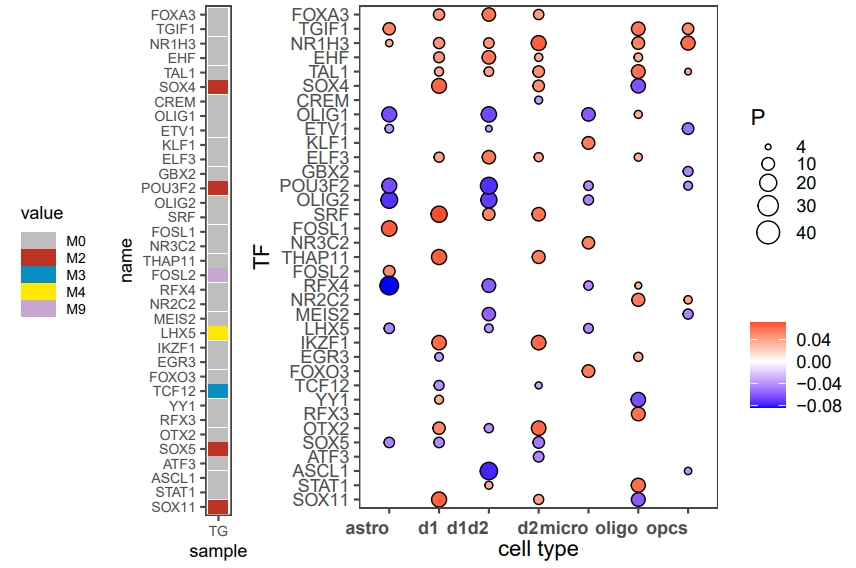

### Epigenetic driver score

In [ ]:
RE_pseudobulk=pd.read_csv('data/RE_pseudobulk.tsv',sep=',',header=0,index_col=0)
K=5
GRN='TF_RE_binding'
adjust_method='bonferroni'
corr_method='pearsonr'
C_result_RE,P_result_RE,Q_result_RE=Compare.driver_score(RE_pseudobulk,metadata,GRN,outdir,adjust_method,corr_method)
C_result_RE_r,Q_result_RE_r=Compare.driver_result(C_result_RE,Q_result_RE,K)
C_result_RE_r.to_csv('C_result_RE_r.txt',sep='\t')
Q_result_RE_r.to_csv('Q_result_RE_r.txt',sep='\t')

#### Visualization

In [ ]:
import os
os.environ['R_HOME'] = '/data2/duren_lab/Kaya/conda_envs/LINGER/lib/R'  # Replace with your actual R home path
import rpy2.robjects as robjects
from rpy2.robjects import r
# Import the R plotting package (ggplot2 as an example)
r('library(ggplot2)')
r('library(grid)')
# Create data in R environment through Python
r('''
dataP=read.table('Q_result_RE_r.txt',sep='\t',row.names=1,header=TRUE)
dataT=read.table('C_result_RE_r.txt',sep='\t',row.names=1,header=TRUE)
sort_TF=rownames(dataT)
library(tidyr)
dataP=-log10(dataP)
print(paste0('maxinum of -log10P:',max(dataP)))
maxP=100
dataP[dataP>100]=100
dataP1=dataP
dataP1$TF=rownames(dataP)
longdiff0 <- gather(dataP1, sample, value,-TF)
longdiff0_s <- longdiff0[order(longdiff0$TF, longdiff0$sample), ]
dataT1=dataT
dataT1$TF=rownames(dataT)
longdiff1=gather(dataT1, sample, value,-TF)
longdiff1=longdiff1[order(longdiff1$TF, longdiff1$sample), ]
colnames(longdiff1)=c('TF','celltype','PCC')
longdiff1$P=longdiff0_s$value
longdiff1$TF=factor(longdiff1$TF,levels=(sort_TF))
library(egg)
cutoff=2
maxp=ceiling(max(dataP))
print(maxp)
limits0=c(cutoff,maxp)
print(limits0)
range0 = c(1,4)
numbreak=5
d=ceiling((maxp-cutoff)/(numbreak-1))
print(d)
breaks0= seq(from = cutoff, to = cutoff+d*(numbreak-1),  length.out=numbreak)

print(range0)
print(breaks0)
p=ggplot(longdiff1,aes(x = celltype, y = TF))+
geom_point(aes(size = P, fill = PCC), alpha = 1, shape = 21) + 
  scale_size_continuous(limits = limits0, range = range0, breaks = breaks0) + 
  labs( x= "cell type", y = "TF", fill = "")  + theme_article()+
  theme(legend.key=element_blank(), 
  axis.text.x = element_text( size = 9, face = "bold", angle = 0, vjust = 0.3, hjust = 1), 
  legend.position = "right") + 
  scale_fill_gradient2(midpoint=0, low="blue", mid="white",
                     high="red", space ="Lab" )


''')
r('''
annotation_row=read.table('Module.txt',sep='\t',header=TRUE,row.names=1)
library(pheatmap)
anno1=data.frame(annotation_row[match(rownames(dataP), rownames(annotation_row)), ])
colnames(anno1)=c('TG')
rownames(anno1)=rownames(dataP)
anno1[is.na(anno1)]=0
anno1[,1]=paste0('M',anno1[,1])
anno1$name=rownames(anno1)
longdiff0 <- gather(anno1, sample, value,-name)
longdiff0$name=factor(longdiff0$name,levels=rownames(anno1))
library("RColorBrewer")
ann_colors = c('M0'="gray", 'M1'='#ffe901','M2'="#be3223",'M3'='#098ec4','M4'='#ffe901','M5'='#f8c9cb','M6'='#f8c9cb',
'M7'='#b2d68c','M8'='#f2f1f6','M9'='#c7a7d2','M10'='#fcba5d')
#ann_colors = list("gray", '#ffe901',"#be3223",'#098ec4','#ffe901','#f8c9cb','#f8c9cb','#b2d68c','#f2f1f6','#c7a7d2','#fcba5d')
heatmap_plot <- ggplot(longdiff0, aes(x = sample, y =name , fill = value)) +
  geom_tile(width = 0.9, height = 0.9) + scale_fill_manual(values=ann_colors) +
  theme_article()+theme(text = element_text(size = 9), legend.position = "left",
 )
  ''')
r('''
widths <- c(4.5, 4.5+dim(dataP)[2]) 
print(unique(longdiff0$value))
pdf('driver_epi.pdf',width=6/16*(9+dim(dataP)[2]),height= dim(anno1)[1]/10+1.5)
#print(p)
grid.arrange(heatmap_plot, p, ncol = 2,widths = widths)
dev.off()
''')

The figure is saved to driver_epi.pdf.
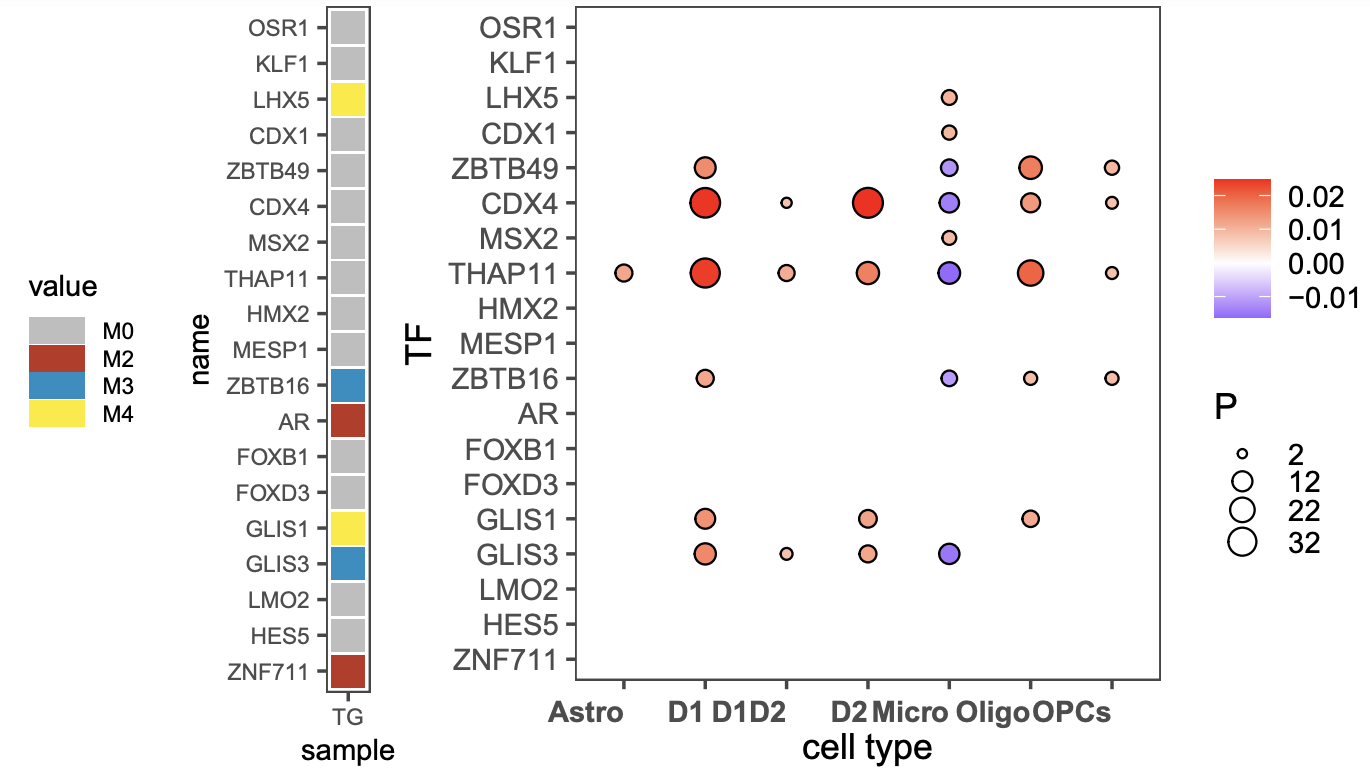